In [9]:
import pandas as pd
import json
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap

In [10]:
data = pd.read_csv('cities.csv')
data.loc[data.Население == '96[3]', 'Население'] = 963
data.loc[data.Индекс == 101000.0, 'Город'] = 'Москва'
data.loc[data.Индекс == 190000.0, 'Город'] = 'Санкт-Петербург'
data.Население = data.Население.astype('int64')

data.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,...,4: город,0,79403000000,7.970300e+10,107,UTC+3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,...,4: город,2,79401000000,7.970100e+10,105,UTC+3,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,...,4: город,2,84401000000,8.470100e+07,400,UTC+7,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,...,4: город,0,1403000000,1.703000e+06,2201,UTC+7,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,...,4: город,2,1401000000,1.701000e+06,2200,UTC+7,53.348115,83.779836,Сибирский,635585


In [11]:
# Select top-30 cities
data = data.sort_values('Население', ascending=False)[:30]

In [12]:
# Delete irrelevant fields
data['Latitude'] = data['Широта'].astype('float')
data['Longitude'] = data['Долгота'].astype('float')
data['City'] = data['Город']
data = data[['City', 'Latitude', 'Longitude']]

In [13]:
data.head()

,City,Latitude,Longitude
506,Москва,55.753879,37.620373
782,Санкт-Петербург,59.939125,30.315822
643,Новосибирск,55.028102,82.921057
828,Екатеринбург,56.838633,60.605489
615,Нижний Новгород,56.324209,44.005395


In [14]:
data.to_csv('top-30.csv')

In [83]:
from matplotlib.animation import FFMpegWriter

class FasterFFMpegWriter(FFMpegWriter):
    '''FFMpeg-pipe writer bypassing figure.savefig.'''
    def __init__(self, **kwargs):
        '''Initialize the Writer object and sets the default frame_format.'''
        super().__init__(**kwargs)
        self.frame_format = 'argb'

    def grab_frame(self, **savefig_kwargs):
        '''Grab the image information from the figure and save as a movie frame.

        Doesn't use savefig to be faster: savefig_kwargs will be ignored.
        '''
        try:
            # re-adjust the figure size and dpi in case it has been changed by the
            # user.  We must ensure that every frame is the same size or
            # the movie will not save correctly.
            self.fig.set_size_inches(self._w, self._h)
            self.fig.set_dpi(self.dpi)
            # Draw and save the frame as an argb string to the pipe sink
            self.fig.canvas.draw()
            self._frame_sink().write(self.fig.canvas.tostring_argb()) 
        except (RuntimeError, IOError) as e:
            out, err = self._proc.communicate()
            raise IOError('Error saving animation to file (cause: {0}) '
                      'Stdout: {1} StdError: {2}. It may help to re-run '
                      'with --verbose-debug.'.format(e, out, err)) 

In [84]:
import random
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
        
def distance_between_cities(city_1, city_2):
    X = (city_2.x - city_1.x) * 40000 * math.cos((city_1.y + city_2.y) * math.pi / 360) / 360
    Y = (city_1.y - city_2.y) * 40000 / 360
    distance = math.sqrt(X ** 2 + Y ** 2)
    return distance

# Class to generate and store path through cities
class Path:
    def __init__(self, city_list):
        self.city_list = city_list
        self.path = []

    def random_path(self):
        self.path = self.city_list.copy()
        random.shuffle(self.path)

    def get_distance(self):
        distance = 0
        for i in range(len(self.path)):
            from_c = self.path[i]
            if i + 1 < len(self.path):
                to_c = self.path[i + 1]
            else:
                to_c = self.path[0]
                
            distance += distance_between_cities(from_c, to_c)

        return distance

class SimulatedAnnealing():
    def __init__(self, city_list, initial_temperature, cooling_rate, save_animation=False):
        self.city_list = city_list
        self.path = Path(city_list)
        self.path.random_path()
        self.temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.animation = save_animation
        if save_animation:
            x = [c.x for c in self.path.path]
            y = [c.y for c in self.path.path]
            
            metadata = dict(title=f'SimulatedAnnealing, cooling rate: {self.cooling_rate}',
                            artist='Ihar Shulhan')
            
            self.fig, self.ax = plt.subplots(figsize=(20, 10))
            self.line, = self.ax.plot(x, y)
            self.ax.axis('off')
            self.moviewriter = FasterFFMpegWriter(fps=15, metadata=metadata)

    def plot_path(self):
        x = [c.x for c in self.path.path]
        y = [c.y for c in self.path.path]
        labels = [c.name for c in self.path.path]

        self.line.set_xdata(x)
        self.line.set_ydata(y)
        self.ax.set_title(f'Temperature: {self.temperature}, Distance: {self.path.get_distance()}')
        for label, x, y in zip(labels, x, y):
            self.ax.annotate(
                label,
                xy=(x, y), xytext=(-1, 1),
                textcoords='offset points', ha='right', va='bottom')
    

    def init(self):
        self.plot_path()
        return self.fig,


    def animate(self):
        self.plot_path()
        return self.fig,

    def accept_solution(self, delta_energy):
        if delta_energy < 0:
            # Ratio is more than 1, solution is accepted in any case
            return True
        elif random.random() <= math.exp(-(delta_energy / self.temperature)):
            # Generate random number from (0, 1) and go only if it is less than our ratio
            return True
        else:
            return False

    def evolve(self):
        new_path = copy.deepcopy(self.path)
        
        pos1 = random.randrange(len(self.city_list))
        pos2 = random.randrange(len(self.city_list))
        
        # Change cities randomly
        city1 = new_path.path[pos1]
        city2 = new_path.path[pos2]
        new_path.path[pos2] = city1
        new_path.path[pos1] = city2
        
        # Calculate new distance
        current_energy = self.path.get_distance()
        new_energy = new_path.get_distance()
        
        # Check if we should accept the solution
        if self.accept_solution(new_energy - current_energy):
            self.path = new_path

    def run(self):
        self.i = 0
        temperatures = []
        iterations = []
        distances = []

        def run_annealing_step(): 
            self.evolve()
            # Decrease the temperature after every iteration
            self.temperature *= 1 - self.cooling_rate

            temperatures.append(self.temperature)
            iterations.append(i)
            distances.append(self.path.get_distance())
            self.i += 1
            
        if not self.animation:
            while self.temperature > 1:
                run_annealing_step()
        else:
            with self.moviewriter.saving(self.fig, "animation.mp4", 100):
                while self.temperature > 1:
                    run_annealing_step()
                    self.animate()
                    self.moviewriter.grab_frame()
            
            
        return temperatures, iterations, distances
    
def plot_map(cities):
    start = cities[0]
    gmap_key = 'PLACEHOLDER_FOR_KEY' # insert google maps key here
    map_in = gmap(gmap_key, map_options=GMapOptions(lat=62, lng=64, zoom=2), tools='save')
    source = ColumnDataSource(dict(lat=[c.y for c in cities], lon=[c.x for c in cities]))
    map_in.circle(start.x, start.y, size=9, fill_color='red') # point start city
    map_in.circle('lon', 'lat', size=5, fill_color='black', source=source)
    
    x = [c.x for c in cities]
    y = [c.y for c in cities]
    
    x.append(start.x)
    y.append(start.y)
    
    map_in.line(x, y, line_width=2) # draw lines between cities
    show(map_in)
    

def plot_metric(arr1, arr2, title):
    p = figure(tools='save', plot_width=1000, plot_height=500)
    p.xaxis.axis_label = 'Iteration'
    p.yaxis.axis_label = title
    p.line(arr1, arr2, line_width=2)
    show(p)
    

# Run algorithm

In [17]:
city_list = []
for i, city_raw in data.iterrows():
    city_list.append(City(city_raw['City'], city_raw['Longitude'], city_raw['Latitude']))
    
plot_map(city_list)

In [56]:
import math

rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_dist = []
results = []

for r in rates:
    simulation = SimulatedAnnealing(city_list, initial_temperature=60000, cooling_rate=r)
    temperatures, iterations, distances = simulation.run()
    best_dist.append(f'Rate: {r}, Distance: {distances[-1]}')
    results.append(simulation.path.path)
    
    plot_metric(iterations, temperatures, 'Temperature')
    plot_metric(iterations, distances, 'Distance')

In [44]:
for d in best_dist:
    print(d)

Rate: 1e-05, Distance: 18043.80938282126
Rate: 0.0001, Distance: 18053.782786952837
Rate: 0.001, Distance: 20094.877823028528
Rate: 0.01, Distance: 22533.30063446432
Rate: 0.1, Distance: 39806.71669373115


In [58]:
', '.join([city.name for city in results[0]])

'Санкт-Петербург, Москва, Воронеж, Ростов-на-Дону, Краснодар, Махачкала, Волгоград, Саратов, Оренбург, Уфа, Челябинск, Омск, Барнаул, Новокузнецк, Иркутск, Владивосток, Хабаровск, Красноярск, Кемерово, Новосибирск, Тюмень, Екатеринбург, Пермь, Ижевск, Самара, Тольятти, Ульяновск, Казань, Нижний Новгород, Ярославль'

In [60]:
plot_map(results[0])

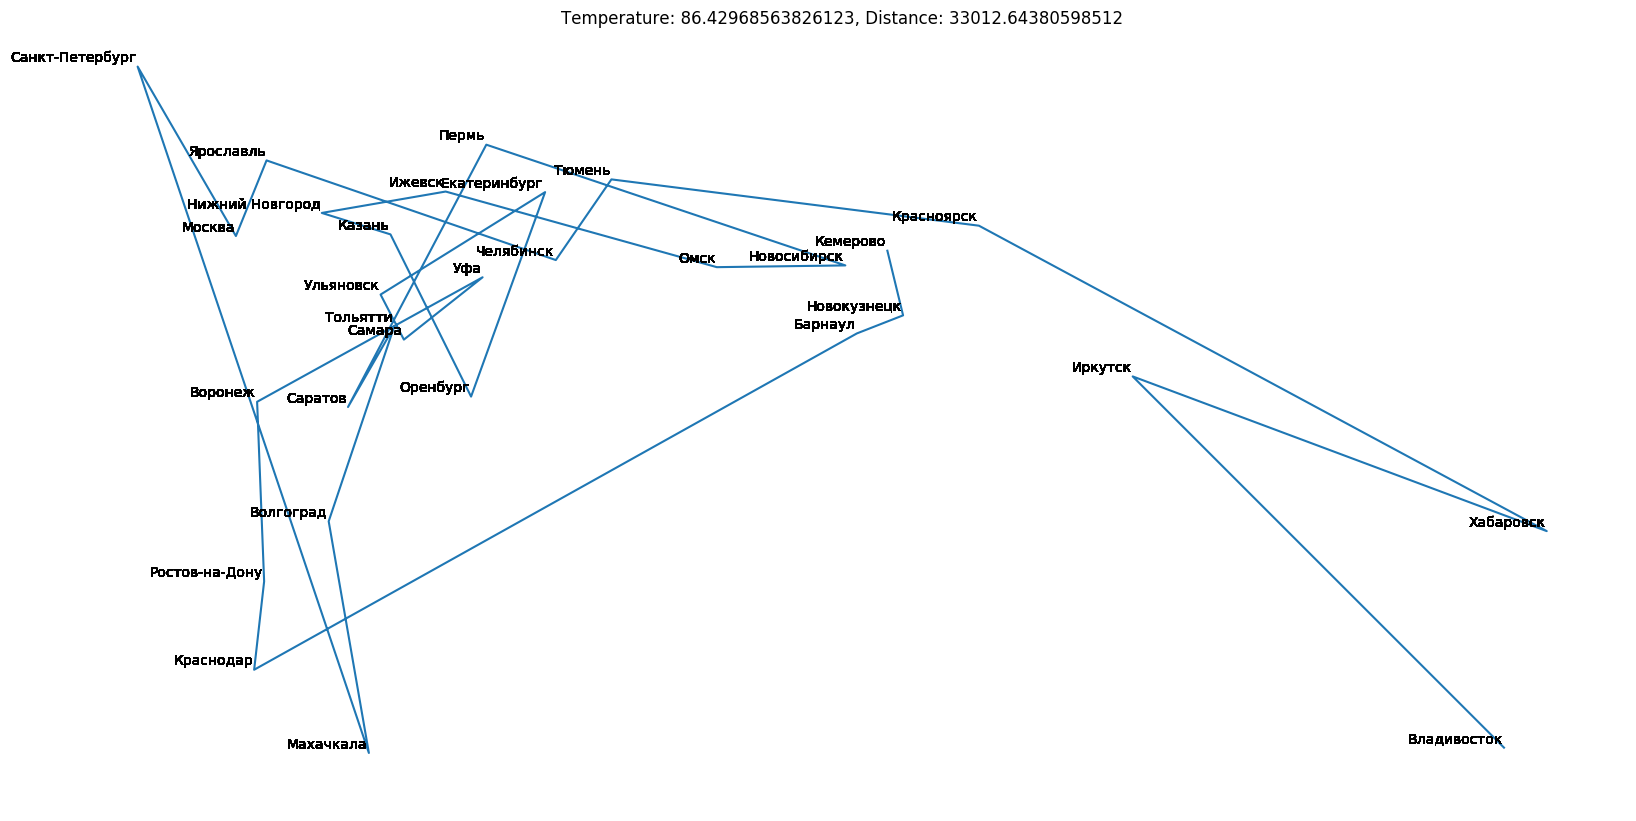

In [85]:
simulation = SimulatedAnnealing(city_list, initial_temperature=60000, cooling_rate=0.01, save_animation=True).run()